#  TP 3 - Reconnaissance de chiffres par classification bayésienne

### Importations

In [1]:
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np

from math import pi as PI

from sklearn.datasets import fetch_openml
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

### Chargement de données 

In [2]:
mnist = fetch_openml("mnist_784")
X, y = mnist["data"], mnist["target"]

### Prétraitement (ACP,standard)


In [3]:
def ACP(X,k):
    M=np.cov(X.T)
    M=np.round(M,10)
    eigen_values,P=np.linalg.eig(M)
    new_P=P[:,:k]
    new_X=np.dot(new_P.T,X.T).T
    
    return eigen_values,P,new_X

def inertie(k,eigen_values):
    total=np.sum(eigen_values)
    return np.sum(eigen_values[:k])/total

def les_inerties(k,eigen_values):
    the_range_inertie=list(range(k+1))
    return the_range_inertie,[ inertie(k,eigen_values) for k in the_range_inertie]

def les_eboulies(k,eigen_values):
    the_range_eboulie=list(range(1,k+1))
    return the_range_eboulie,[ eigen_values[k-1] for k in the_range_eboulie]

def show_inertie_eboulie(n_first_components,eigen_values):
    #calculs
    the_range_inertie,inertie=les_inerties(n_first_components,eigen_values)
    the_range_eboulie,eboulie=les_eboulies(n_first_components,eigen_values)
    #affichages
    fig, axs = plt.subplots(1,2)
    fig.set_figheight(4)
    fig.set_figwidth(12)
    axs[0].plot(the_range_inertie,inertie)
    axs[0].set_xlabel(f'{n_first_components} premieres composantes')
    axs[0].set_ylabel('inertie')
    axs[0].set_title(f'Inertie des {n_first_components} premiere composantes')
    axs[1].bar(the_range_eboulie,eboulie,1)
    axs[1].set_xlabel(f'{n_first_components} premieres composantes')
    axs[1].set_ylabel('eboulie')
    axs[1].set_title(f'Eboulie   des {n_first_components} premiere composantes')



In [4]:
eigen_values,P,new_X=ACP(X,150)

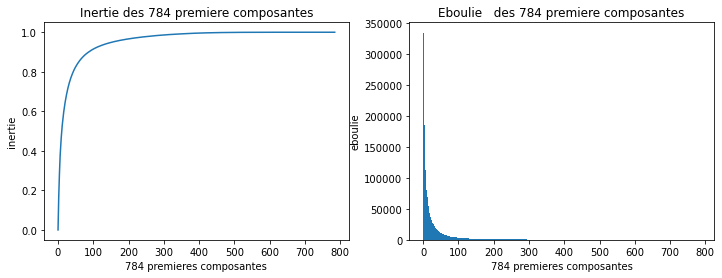

In [5]:
show_inertie_eboulie(784,eigen_values)

In [6]:
def standard(X):
    return (X-np.mean(X,axis=0))/np.std(X,axis=0) #axe des variables sont les colonnes
def data_split(X,y,nb_a,nb_t):
    X=standard(X)
    Xa=np.asarray(X[:nb_a])
    Xt=np.asarray(X[X.shape[0]-nb_t:])
    Ya=np.asarray([int(y1) for y1 in y[:nb_a]])
    Yt=np.asarray([int(y1) for y1 in y[X.shape[0]-nb_t:]])
    return Xa,Xt,Ya,Yt

#Split données réduites et normalisées
Xa,Xt,Ya,Yt = data_split(new_X,y,60000,4000)
print(Xa.shape,Xt.shape,Ya.shape,Yt.shape)


(60000, 150) (4000, 150) (60000,) (4000,)


<div class="alert alert-block alert-info">
<b>Réponse:</b> 150 composantes devraient garder assez d'information. </div>

## Classification bayesienne

In [7]:
class GaussianBayes(object):
    """ Classification bayesienne Gaussienne
    """
    def __init__(self,nb_class,prior=False) -> None:
        self.prior=prior # naif ou non
                                # (n_classes,)
        self.mu = None          #  mean of each feature per class
                                # (n_classes, n_features)
        self.sigma = None       # covariance of each feature per class
        self.nb_class=nb_class                  # (n_classes, n_features, n_features)
        
        


    def fit(self, X:np.ndarray, y:np.ndarray, ) -> None:
        """Learning : estime self.mu et self.sigma
        
        X : shape (n_data, n_features)
        y : shape (n_data)
        """
        self.mu=np.array([ np.mean(X[np.where(y==i)],axis=0) for i in range(self.nb_class) ])
        self.sigma=np.array([ np.cov(X[np.where(y==i)].T) for i in range(self.nb_class) ])
       
        if self.prior:
            tp,nb_tp=np.unique(y,return_counts=True)
            priors= [ nb/sum(nb_tp) for nb in nb_tp]
            self.priors = np.array(priors)    # proba a priori
        else:
            self.priors = np.array([1 for _ in range(self.nb_class)])
            

    def predict(self, X:np.ndarray) -> np.ndarray:
        """retourne un vecteur de prédictions sur X contenant les indices des classes prédites

        X shape = [n_samples, n_features]
        maximum log-likelihood
        """
        det=np.array([ np.linalg.det(self.sigma[i]) for i in range(self.nb_class) ])
        P=[]
        for i in range(self.nb_class):
            C1=X-self.mu[i]
            C1_T=C1.T
            S=np.linalg.inv(self.sigma[i])
            B=(-1/2)*np.dot(C1.dot(S),C1_T)   #pas d'exponentielle car log
            A=np.log(1/((2*PI)**(self.nb_class/2)*det[i]**0.5))
            P.append(A+B) #somme car log
       
        P1=np.array([ np.diag(P[i]) for i in range(self.nb_class) ]).T
        P1=(-P1*self.priors)
        prediction = np.argsort(P1, axis=1)[:,:1]
        return np.ravel(prediction)

In [8]:
test=GaussianBayes(10,False)
test.fit(Xa,Ya)

In [9]:
print(test.mu.shape)
print(test.sigma.shape)

(10, 150)
[ 1.72699048 -0.34252794  0.29608032 -0.28525826  1.31332212]
(10, 150, 150)
[6.72217940e-046 3.81395642e-151 1.14779870e-024 2.95334156e-029
 4.95833120e-044 1.62082871e-030 4.19181071e-070 1.01857878e-076
 1.85195829e-023 1.00291802e-068]


In [10]:
pred=test.predict(Xt)
print(pred.shape)

(4000,)


### Evaluation de la classification

In [11]:
score=sum(y_true==y_pred for y_true,y_pred in zip(Yt,pred))/Yt.shape[0]
print(f'Precision : {round(score*100,2)}%')

Precision : 96.92%


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       412
           1       1.00      0.96      0.98       449
           2       0.95      0.97      0.96       407
           3       0.97      0.95      0.96       415
           4       0.98      0.99      0.99       383
           5       0.97      0.97      0.97       344
           6       0.98      0.98      0.98       396
           7       0.97      0.97      0.97       419
           8       0.90      0.98      0.93       387
           9       0.99      0.94      0.96       388

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000



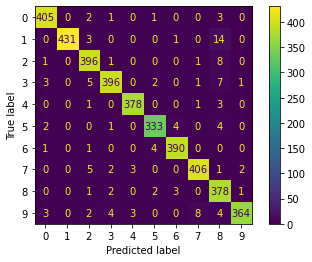

In [12]:
cm = confusion_matrix(Yt,pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(classification_report(Yt,pred))

<div class="alert alert-block alert-info">
<b>Réponse:</b> L'erreur la plus fréquente est de classer un 8 en 1 ( 14 occurences ).

Néamoins, aucun 1 n'est mal classé.
</div>